# Подбор гиперпараметров для Combined модели

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import json
from tqdm import tqdm

In [2]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Device: {device}')

Device: mps


## Загрузка данных

In [3]:
import random

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

data = torch.load('../data/Mushrooms_preprocessed.pt')
images = data['images']
labels = data['labels']

dataset = TensorDataset(images, labels)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader_main = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader_main = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

print(f'Train: {train_size}, Test: {test_size}')

Train: 5371, Test: 1343


## Combined модель (с параметрами dropout)

In [4]:
class CombinedCNN(nn.Module):
    def __init__(self, num_classes=9, dropout_conv=0.3, dropout_fc=0.5):
        super(CombinedCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(dropout_conv)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(dropout_conv)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(dropout_conv + 0.1)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.dropout4 = nn.Dropout(dropout_conv + 0.1)
        
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool5 = nn.MaxPool2d(2, 2)
        self.dropout5 = nn.Dropout(dropout_conv + 0.2)
        
        self.fc1 = nn.Linear(512 * 4 * 4, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.dropout_fc1 = nn.Dropout(dropout_fc + 0.1)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn_fc2 = nn.BatchNorm1d(256)
        self.dropout_fc2 = nn.Dropout(dropout_fc)
        
        self.fc3 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)
        
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout3(x)
        
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout4(x)
        
        x = self.pool5(F.relu(self.bn5(self.conv5(x))))
        x = self.dropout5(x)
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout_fc1(x)
        
        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout_fc2(x)
        
        x = self.fc3(x)
        return x

## Функция обучения

In [5]:
def train_model(model, train_loader, test_loader, lr, weight_decay, num_epochs=30):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
    
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * train_correct / train_total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        model.eval()
        test_running_loss = 0.0
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                test_running_loss += loss.item()
                _, predicted = outputs.max(1)
                test_total += targets.size(0)
                test_correct += predicted.eq(targets).sum().item()
        
        test_loss = test_running_loss / len(test_loader)
        test_acc = 100. * test_correct / test_total
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        scheduler.step(test_acc)
    
    max_test_acc = max(test_accs)
    return max_test_acc, train_losses, test_losses, train_accs, test_accs

## 1. Grid Search: LR + Weight Decay

In [6]:
lr_values = [1e-4, 5e-4, 1e-3]
wd_values = [1e-5, 1e-4, 5e-4]

results_lr_wd = []

g = torch.Generator()
g.manual_seed(42)

for lr in lr_values:
    for wd in wd_values:
        print(f'\nTesting lr={lr}, wd={wd}')
        
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, generator=g)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
        
        model = CombinedCNN(dropout_conv=0.3, dropout_fc=0.5)
        max_acc, train_losses, test_losses, train_accs, test_accs = train_model(model, train_loader, test_loader, lr=lr, weight_decay=wd, num_epochs=30)
        
        results_lr_wd.append({
            'lr': lr,
            'wd': wd,
            'max_acc': max_acc,
            'train_losses': train_losses,
            'test_losses': test_losses,
            'train_accs': train_accs,
            'test_accs': test_accs
        })
        
        print(f'Max Test Acc: {max_acc:.2f}%')
        
        del model
        torch.mps.empty_cache()


Testing lr=0.0001, wd=1e-05


KeyboardInterrupt: 

In [ ]:
best_lr_wd = max(results_lr_wd, key=lambda x: x['max_acc'])
print(f"\nЛучшие LR + WD: lr={best_lr_wd['lr']}, wd={best_lr_wd['wd']}, acc={best_lr_wd['max_acc']:.2f}%")

if best_lr_wd['max_acc'] < 20:
    print('данные и random_split!')


Лучшие LR + WD: lr=0.001, wd=1e-05, acc=64.26%


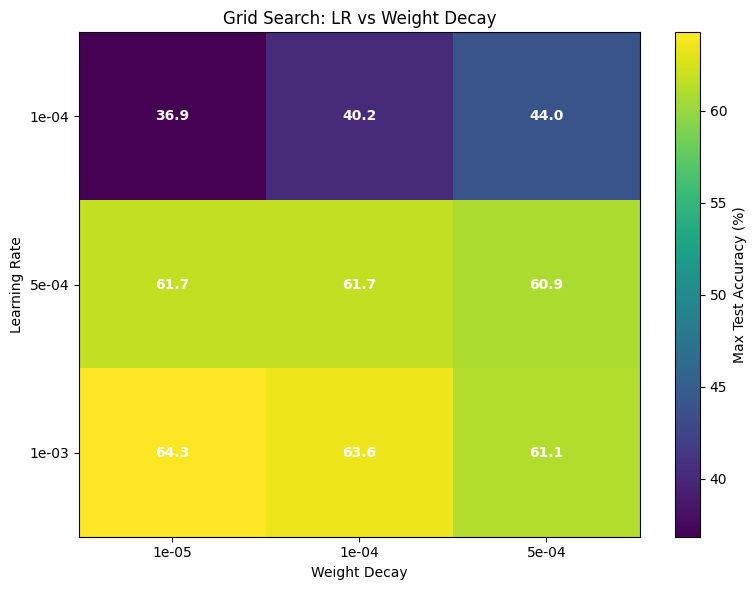

In [ ]:
acc_matrix = np.zeros((len(lr_values), len(wd_values)))

for res in results_lr_wd:
    i = lr_values.index(res['lr'])
    j = wd_values.index(res['wd'])
    acc_matrix[i, j] = res['max_acc']

plt.figure(figsize=(8, 6))
plt.imshow(acc_matrix, cmap='viridis', aspect='auto')
plt.colorbar(label='Max Test Accuracy (%)')
plt.xticks(range(len(wd_values)), [f'{wd:.0e}' for wd in wd_values])
plt.yticks(range(len(lr_values)), [f'{lr:.0e}' for lr in lr_values])
plt.xlabel('Weight Decay')
plt.ylabel('Learning Rate')
plt.title('Grid Search: LR vs Weight Decay')

for i in range(len(lr_values)):
    for j in range(len(wd_values)):
        plt.text(j, i, f'{acc_matrix[i, j]:.1f}', ha='center', va='center', color='white', fontweight='bold')

plt.tight_layout()
plt.show()

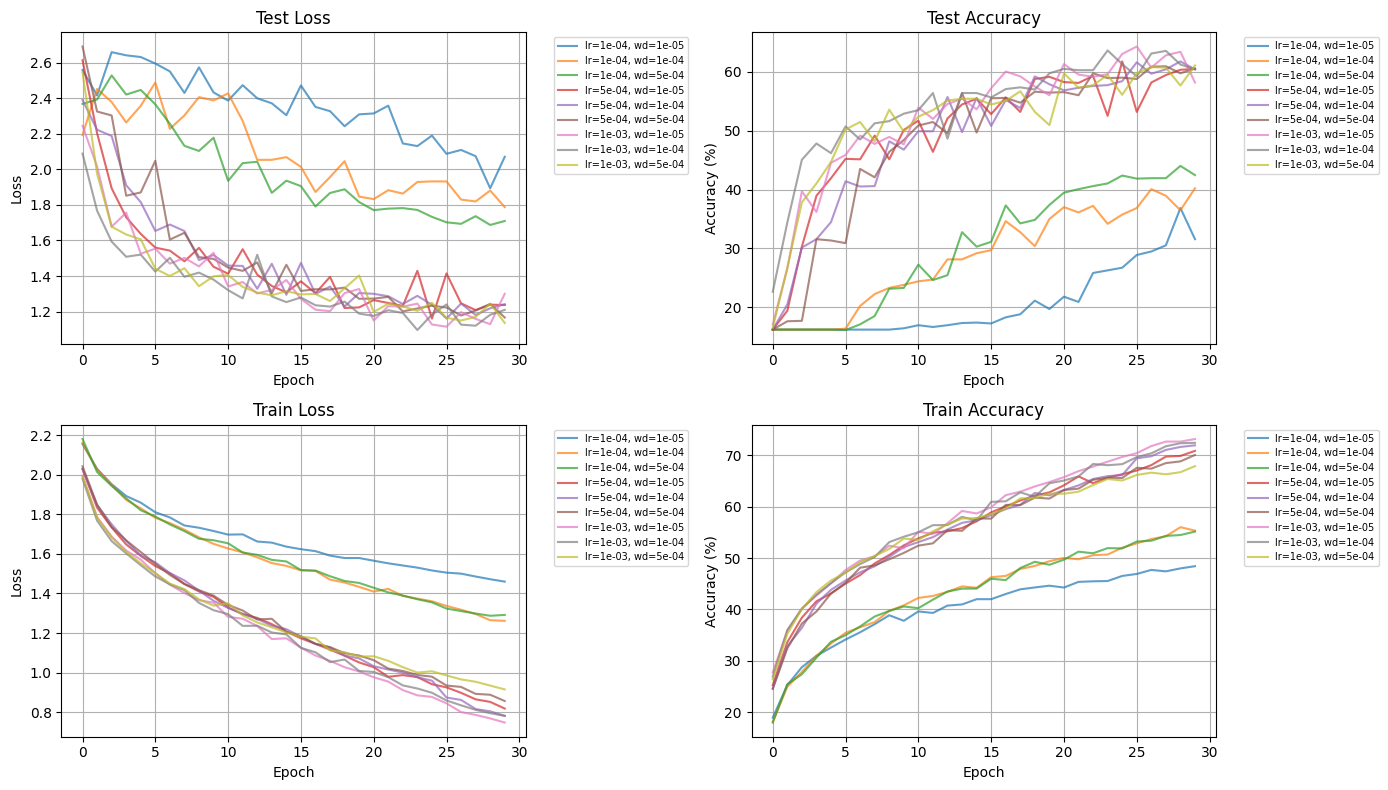

In [ ]:
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
for res in results_lr_wd:
    label = f"lr={res['lr']:.0e}, wd={res['wd']:.0e}"
    plt.plot(res['test_losses'], label=label, alpha=0.7)
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)
plt.grid()

plt.subplot(2, 2, 2)
for res in results_lr_wd:
    label = f"lr={res['lr']:.0e}, wd={res['wd']:.0e}"
    plt.plot(res['test_accs'], label=label, alpha=0.7)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)
plt.grid()

plt.subplot(2, 2, 3)
for res in results_lr_wd:
    label = f"lr={res['lr']:.0e}, wd={res['wd']:.0e}"
    plt.plot(res['train_losses'], label=label, alpha=0.7)
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)
plt.grid()

plt.subplot(2, 2, 4)
for res in results_lr_wd:
    label = f"lr={res['lr']:.0e}, wd={res['wd']:.0e}"
    plt.plot(res['train_accs'], label=label, alpha=0.7)
plt.title('Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)
plt.grid()

plt.tight_layout()
plt.show()

## 2. Grid Search: Dropout

In [ ]:
# dropout_conv_values = [0.2, 0.3, 0.4]
# dropout_fc_values = [0.4, 0.5, 0.6]

# best_lr = best_lr_wd['lr']
# best_wd = best_lr_wd['wd']

# results_dropout = []

# g = torch.Generator()
# g.manual_seed(42)

# for dc in dropout_conv_values:
#     for df in dropout_fc_values:
#         print(f'\nTesting dropout_conv={dc}, dropout_fc={df}')
        
#         train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, generator=g)
#         test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
        
#         model = CombinedCNN(dropout_conv=dc, dropout_fc=df)
#         max_acc, train_losses, test_losses, train_accs, test_accs = train_model(model, train_loader, test_loader, lr=best_lr, weight_decay=best_wd, num_epochs=30)
        
#         results_dropout.append({
#             'dropout_conv': dc,
#             'dropout_fc': df,
#             'max_acc': max_acc,
#             'train_losses': train_losses,
#             'test_losses': test_losses,
#             'train_accs': train_accs,
#             'test_accs': test_accs
#         })
        
#         print(f'Max Test Acc: {max_acc:.2f}%')
        
#         del model
#         torch.mps.empty_cache()


Testing dropout_conv=0.2, dropout_fc=0.4
Max Test Acc: 64.78%

Testing dropout_conv=0.2, dropout_fc=0.5
Max Test Acc: 63.14%

Testing dropout_conv=0.2, dropout_fc=0.6
Max Test Acc: 63.44%

Testing dropout_conv=0.3, dropout_fc=0.4
Max Test Acc: 61.88%

Testing dropout_conv=0.3, dropout_fc=0.5
Max Test Acc: 62.99%

Testing dropout_conv=0.3, dropout_fc=0.6
Max Test Acc: 62.10%

Testing dropout_conv=0.4, dropout_fc=0.4


KeyboardInterrupt: 

## 2.1. Grid Search: Расширенный поиск LR + Weight Decay

In [27]:
lr_values_extended = [1e-3, 5e-3, 1e-2]
wd_values_extended = [1e-6, 5e-6, 1e-5]

results_lr_wd_extended = []

g = torch.Generator()
g.manual_seed(42)

for lr in lr_values_extended:
    for wd in wd_values_extended:
        print(f'\nTesting lr={lr}, wd={wd}')
        
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, generator=g)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
        
        model = CombinedCNN(dropout_conv=0.3, dropout_fc=0.5)
        max_acc, train_losses, test_losses, train_accs, test_accs = train_model(model, train_loader, test_loader, lr=lr, weight_decay=wd, num_epochs=30)
        
        results_lr_wd_extended.append({
            'lr': lr,
            'wd': wd,
            'max_acc': max_acc,
            'train_losses': train_losses,
            'test_losses': test_losses,
            'train_accs': train_accs,
            'test_accs': test_accs
        })
        
        print(f'Max Test Acc: {max_acc:.2f}%')
        
        del model
        torch.mps.empty_cache()


Testing lr=0.001, wd=1e-06


KeyboardInterrupt: 

In [ ]:
best_lr_wd_extended = max(results_lr_wd_extended, key=lambda x: x['max_acc'])
print(f"\nЛучшие расширенные LR + WD: lr={best_lr_wd_extended['lr']}, wd={best_lr_wd_extended['wd']}, acc={best_lr_wd_extended['max_acc']:.2f}%")

if best_lr_wd_extended['max_acc'] < 20:
    print('\nрезультаты < 20%!')


Лучшие расширенные LR + WD: lr=0.001, wd=1e-05, acc=63.66%


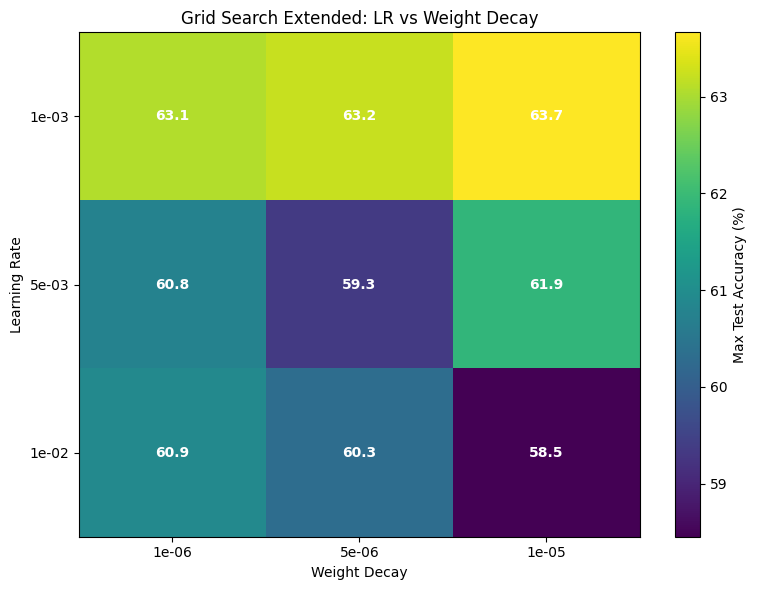

In [ ]:
acc_matrix_ext = np.zeros((len(lr_values_extended), len(wd_values_extended)))

for res in results_lr_wd_extended:
    i = lr_values_extended.index(res['lr'])
    j = wd_values_extended.index(res['wd'])
    acc_matrix_ext[i, j] = res['max_acc']

plt.figure(figsize=(8, 6))
plt.imshow(acc_matrix_ext, cmap='viridis', aspect='auto')
plt.colorbar(label='Max Test Accuracy (%)')
plt.xticks(range(len(wd_values_extended)), [f'{wd:.0e}' for wd in wd_values_extended])
plt.yticks(range(len(lr_values_extended)), [f'{lr:.0e}' for lr in lr_values_extended])
plt.xlabel('Weight Decay')
plt.ylabel('Learning Rate')
plt.title('Grid Search Extended: LR vs Weight Decay')

for i in range(len(lr_values_extended)):
    for j in range(len(wd_values_extended)):
        plt.text(j, i, f'{acc_matrix_ext[i, j]:.1f}', ha='center', va='center', color='white', fontweight='bold')

plt.tight_layout()
plt.show()

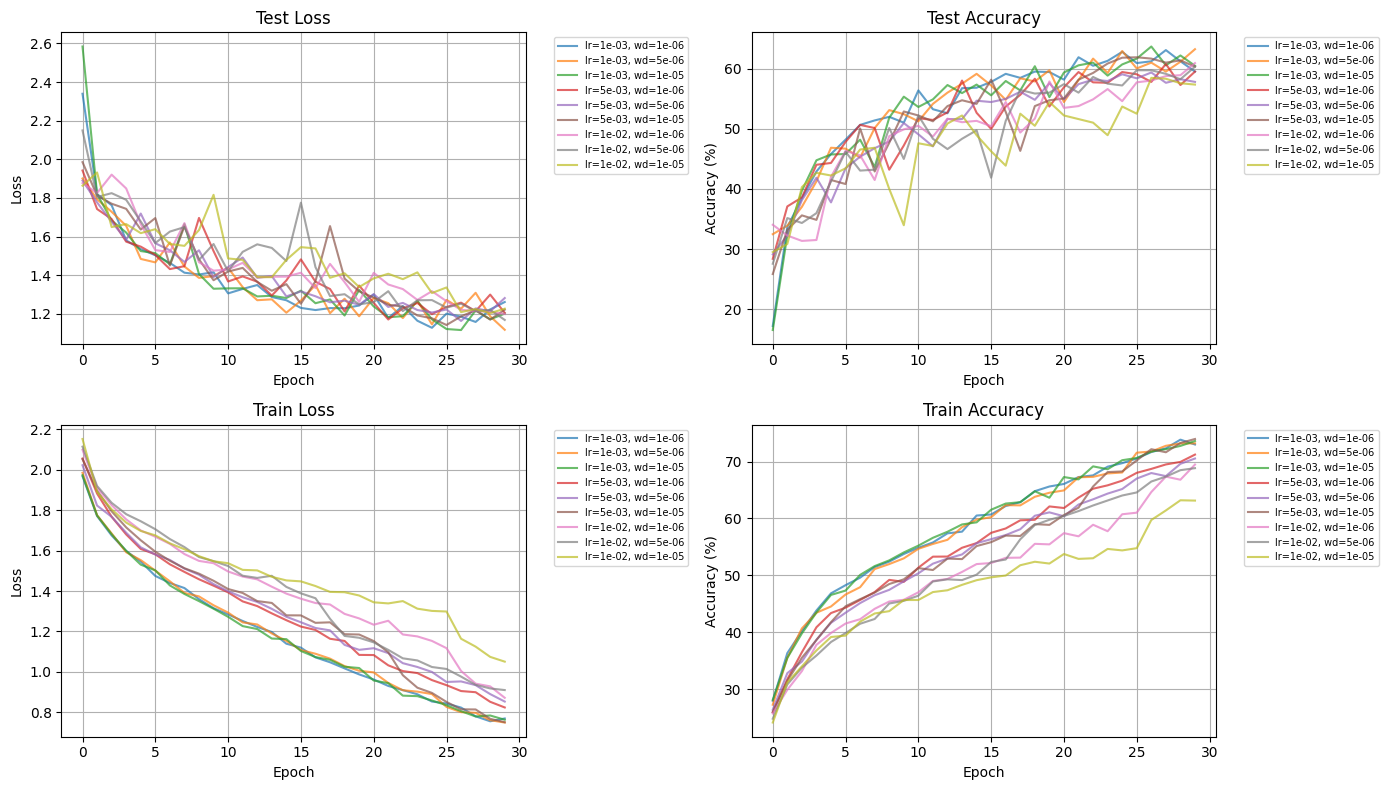

In [ ]:
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
for res in results_lr_wd_extended:
    label = f"lr={res['lr']:.0e}, wd={res['wd']:.0e}"
    plt.plot(res['test_losses'], label=label, alpha=0.7)
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)
plt.grid()

plt.subplot(2, 2, 2)
for res in results_lr_wd_extended:
    label = f"lr={res['lr']:.0e}, wd={res['wd']:.0e}"
    plt.plot(res['test_accs'], label=label, alpha=0.7)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)
plt.grid()

plt.subplot(2, 2, 3)
for res in results_lr_wd_extended:
    label = f"lr={res['lr']:.0e}, wd={res['wd']:.0e}"
    plt.plot(res['train_losses'], label=label, alpha=0.7)
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)
plt.grid()

plt.subplot(2, 2, 4)
for res in results_lr_wd_extended:
    label = f"lr={res['lr']:.0e}, wd={res['wd']:.0e}"
    plt.plot(res['train_accs'], label=label, alpha=0.7)
plt.title('Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)
plt.grid()

plt.tight_layout()
plt.show()

## 2.2. Grid Search: Dropout с масштабированием архитектуры

In [11]:
def calculate_architecture(dropout_conv, dropout_fc):
    target_active = {
        'conv1': 26,
        'conv2': 51,
        'conv3': 90,
        'conv4': 179,
        'conv5': 307,
        'fc1': 256,
        'fc2': 154,
    }
    
    dropout_rates = {
        'conv1': dropout_conv,
        'conv2': dropout_conv,
        'conv3': dropout_conv + 0.1,
        'conv4': dropout_conv + 0.1,
        'conv5': dropout_conv + 0.2,
        'fc1': dropout_fc + 0.1,
        'fc2': dropout_fc,
    }
    
    channels = {}
    for layer, active in target_active.items():
        dropout = dropout_rates[layer]
        required = int(active / (1 - dropout))
        channels[layer] = required
    
    return channels

test_arch = calculate_architecture(0.2, 0.4)
print('Тест архитектуры для dc=0.2, df=0.4:')
for layer, ch in test_arch.items():
    print(f'{layer}: {ch}')

Тест архитектуры для dc=0.2, df=0.4:
conv1: 32
conv2: 63
conv3: 128
conv4: 255
conv5: 511
fc1: 512
fc2: 256


In [12]:
class ScalableCombinedCNN(nn.Module):
    def __init__(self, channels, num_classes=9, dropout_conv=0.3, dropout_fc=0.5):
        super(ScalableCombinedCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, channels['conv1'], kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels['conv1'])
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(dropout_conv)
        
        self.conv2 = nn.Conv2d(channels['conv1'], channels['conv2'], kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels['conv2'])
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(dropout_conv)
        
        self.conv3 = nn.Conv2d(channels['conv2'], channels['conv3'], kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(channels['conv3'])
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(dropout_conv + 0.1)
        
        self.conv4 = nn.Conv2d(channels['conv3'], channels['conv4'], kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(channels['conv4'])
        self.pool4 = nn.MaxPool2d(2, 2)
        self.dropout4 = nn.Dropout(dropout_conv + 0.1)
        
        self.conv5 = nn.Conv2d(channels['conv4'], channels['conv5'], kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(channels['conv5'])
        self.pool5 = nn.MaxPool2d(2, 2)
        self.dropout5 = nn.Dropout(dropout_conv + 0.2)
        
        flatten_size = channels['conv5'] * 4 * 4
        self.fc1 = nn.Linear(flatten_size, channels['fc1'])
        self.bn_fc1 = nn.BatchNorm1d(channels['fc1'])
        self.dropout_fc1 = nn.Dropout(dropout_fc + 0.1)
        
        self.fc2 = nn.Linear(channels['fc1'], channels['fc2'])
        self.bn_fc2 = nn.BatchNorm1d(channels['fc2'])
        self.dropout_fc2 = nn.Dropout(dropout_fc)
        
        self.fc3 = nn.Linear(channels['fc2'], num_classes)
    
    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)
        
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout3(x)
        
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout4(x)
        
        x = self.pool5(F.relu(self.bn5(self.conv5(x))))
        x = self.dropout5(x)
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout_fc1(x)
        
        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout_fc2(x)
        
        x = self.fc3(x)
        return x

test_model = ScalableCombinedCNN(test_arch, dropout_conv=0.2, dropout_fc=0.4).to(device)
print(f'\nТестовая модель создана, всего параметров: {sum(p.numel() for p in test_model.parameters()):,}')


Тестовая модель создана, всего параметров: 5,882,857


In [13]:
dropout_conv_values_scaled = [0.2, 0.3, 0.4]
dropout_fc_values_scaled = [0.4, 0.5, 0.6]

best_lr_final = best_lr_wd_extended['lr']
best_wd_final = best_lr_wd_extended['wd']

results_dropout_scaled = []

g = torch.Generator()
g.manual_seed(42)

for dc in dropout_conv_values_scaled:
    for df in dropout_fc_values_scaled:
        print(f'\nTesting scaled dropout_conv={dc}, dropout_fc={df}')
        
        channels = calculate_architecture(dc, df)
        print(f'Архитектура: conv1={channels["conv1"]}, conv5={channels["conv5"]}, fc1={channels["fc1"]}')
        
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, generator=g)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
        
        model = ScalableCombinedCNN(channels, dropout_conv=dc, dropout_fc=df)
        max_acc, train_losses, test_losses, train_accs, test_accs = train_model(model, train_loader, test_loader, lr=best_lr_final, weight_decay=best_wd_final, num_epochs=30)
        
        results_dropout_scaled.append({
            'dropout_conv': dc,
            'dropout_fc': df,
            'channels': channels,
            'max_acc': max_acc,
            'train_losses': train_losses,
            'test_losses': test_losses,
            'train_accs': train_accs,
            'test_accs': test_accs
        })
        
        print(f'Max Test Acc: {max_acc:.2f}%')
        
        del model
        torch.mps.empty_cache()


Testing scaled dropout_conv=0.2, dropout_fc=0.4
Архитектура: conv1=32, conv5=511, fc1=512
Max Test Acc: 62.92%

Testing scaled dropout_conv=0.2, dropout_fc=0.5
Архитектура: conv1=32, conv5=511, fc1=640
Max Test Acc: 63.29%

Testing scaled dropout_conv=0.2, dropout_fc=0.6
Архитектура: conv1=32, conv5=511, fc1=853
Max Test Acc: 62.70%

Testing scaled dropout_conv=0.3, dropout_fc=0.4
Архитектура: conv1=37, conv5=614, fc1=512
Max Test Acc: 63.66%

Testing scaled dropout_conv=0.3, dropout_fc=0.5
Архитектура: conv1=37, conv5=614, fc1=640
Max Test Acc: 63.37%

Testing scaled dropout_conv=0.3, dropout_fc=0.6
Архитектура: conv1=37, conv5=614, fc1=853
Max Test Acc: 64.04%

Testing scaled dropout_conv=0.4, dropout_fc=0.4
Архитектура: conv1=43, conv5=767, fc1=512
Max Test Acc: 61.80%

Testing scaled dropout_conv=0.4, dropout_fc=0.5
Архитектура: conv1=43, conv5=767, fc1=640
Max Test Acc: 62.40%

Testing scaled dropout_conv=0.4, dropout_fc=0.6
Архитектура: conv1=43, conv5=767, fc1=853
Max Test Acc:

In [14]:
best_dropout_scaled = max(results_dropout_scaled, key=lambda x: x['max_acc'])
print(f"\nЛучшие Dropout (scaled): conv={best_dropout_scaled['dropout_conv']}, fc={best_dropout_scaled['dropout_fc']}, acc={best_dropout_scaled['max_acc']:.2f}%")


Лучшие Dropout (scaled): conv=0.3, fc=0.6, acc=64.04%


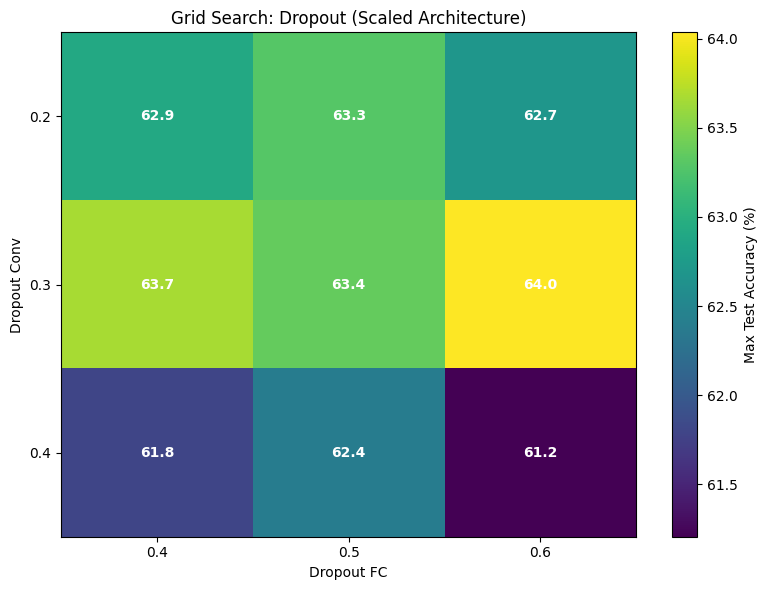

In [15]:
dropout_matrix_scaled = np.zeros((len(dropout_conv_values_scaled), len(dropout_fc_values_scaled)))

for res in results_dropout_scaled:
    i = dropout_conv_values_scaled.index(res['dropout_conv'])
    j = dropout_fc_values_scaled.index(res['dropout_fc'])
    dropout_matrix_scaled[i, j] = res['max_acc']

plt.figure(figsize=(8, 6))
plt.imshow(dropout_matrix_scaled, cmap='viridis', aspect='auto')
plt.colorbar(label='Max Test Accuracy (%)')
plt.xticks(range(len(dropout_fc_values_scaled)), dropout_fc_values_scaled)
plt.yticks(range(len(dropout_conv_values_scaled)), dropout_conv_values_scaled)
plt.xlabel('Dropout FC')
plt.ylabel('Dropout Conv')
plt.title('Grid Search: Dropout (Scaled Architecture)')

for i in range(len(dropout_conv_values_scaled)):
    for j in range(len(dropout_fc_values_scaled)):
        plt.text(j, i, f'{dropout_matrix_scaled[i, j]:.1f}', ha='center', va='center', color='white', fontweight='bold')

plt.tight_layout()
plt.show()

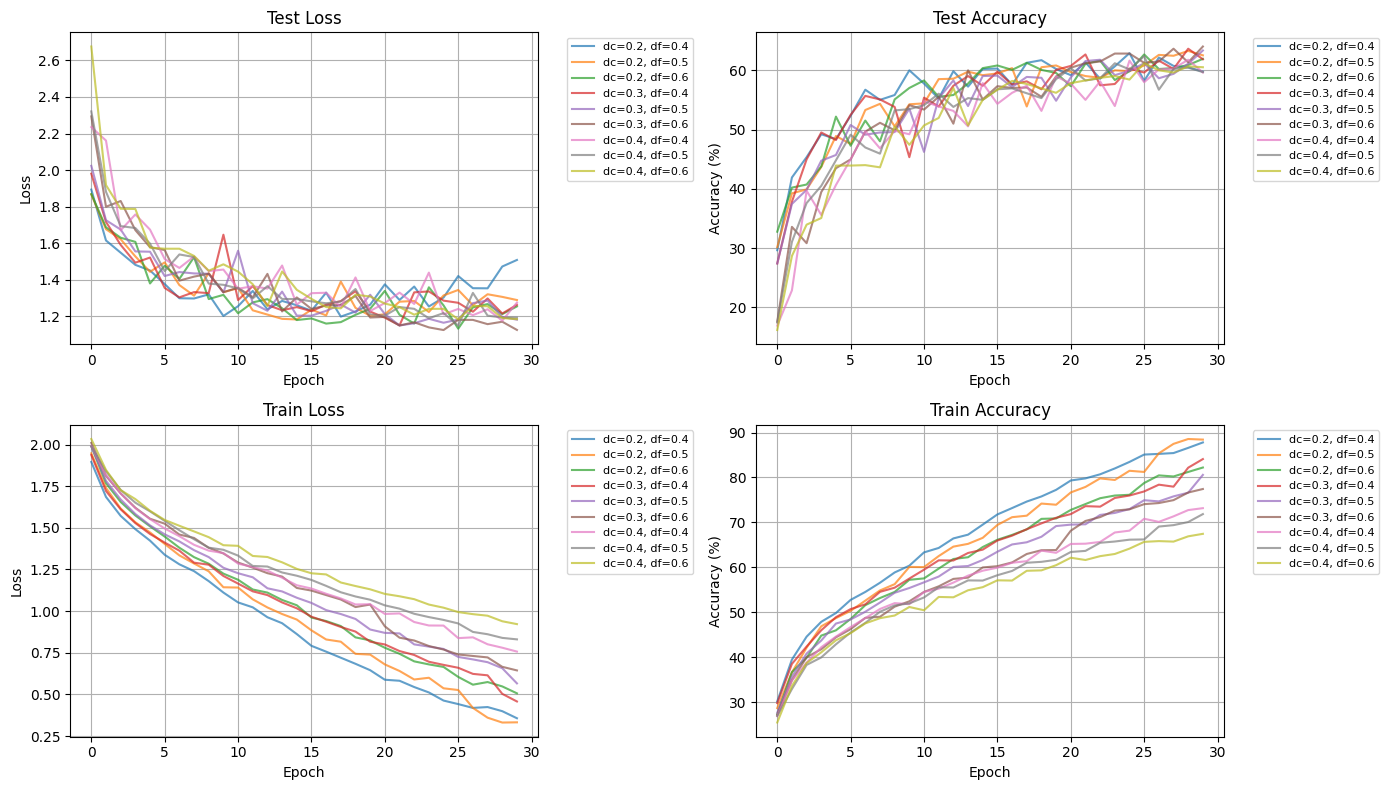

In [16]:
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
for res in results_dropout_scaled:
    label = f"dc={res['dropout_conv']}, df={res['dropout_fc']}"
    plt.plot(res['test_losses'], label=label, alpha=0.7)
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid()

plt.subplot(2, 2, 2)
for res in results_dropout_scaled:
    label = f"dc={res['dropout_conv']}, df={res['dropout_fc']}"
    plt.plot(res['test_accs'], label=label, alpha=0.7)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid()

plt.subplot(2, 2, 3)
for res in results_dropout_scaled:
    label = f"dc={res['dropout_conv']}, df={res['dropout_fc']}"
    plt.plot(res['train_losses'], label=label, alpha=0.7)
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid()

plt.subplot(2, 2, 4)
for res in results_dropout_scaled:
    label = f"dc={res['dropout_conv']}, df={res['dropout_fc']}"
    plt.plot(res['train_accs'], label=label, alpha=0.7)
plt.title('Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid()

plt.tight_layout()
plt.show()

## 3. Grid Search: Batch Size

In [17]:
batch_sizes = [16, 32, 64, 128]

best_dc_final = best_dropout_scaled['dropout_conv']
best_df_final = best_dropout_scaled['dropout_fc']
best_channels_final = best_dropout_scaled['channels']

results_batch_final = []

for bs in batch_sizes:
    print(f'\nTesting batch_size={bs}')
    
    g = torch.Generator()
    g.manual_seed(42)
    
    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=0, generator=g)
    test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False, num_workers=0)
    
    model = ScalableCombinedCNN(best_channels_final, dropout_conv=best_dc_final, dropout_fc=best_df_final)
    max_acc, train_losses, test_losses, train_accs, test_accs = train_model(model, train_loader, test_loader, lr=best_lr_final, weight_decay=best_wd_final, num_epochs=30)
    
    results_batch_final.append({
        'batch_size': bs,
        'max_acc': max_acc,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accs': train_accs,
        'test_accs': test_accs
    })
    
    print(f'Max Test Acc: {max_acc:.2f}%')
    
    del model
    torch.mps.empty_cache()


Testing batch_size=16
Max Test Acc: 62.84%

Testing batch_size=32
Max Test Acc: 62.40%

Testing batch_size=64
Max Test Acc: 63.14%

Testing batch_size=128
Max Test Acc: 60.61%


In [18]:
best_batch_final = max(results_batch_final, key=lambda x: x['max_acc'])
print(f"\nЛучший Batch Size: {best_batch_final['batch_size']}, acc={best_batch_final['max_acc']:.2f}%")


Лучший Batch Size: 64, acc=63.14%


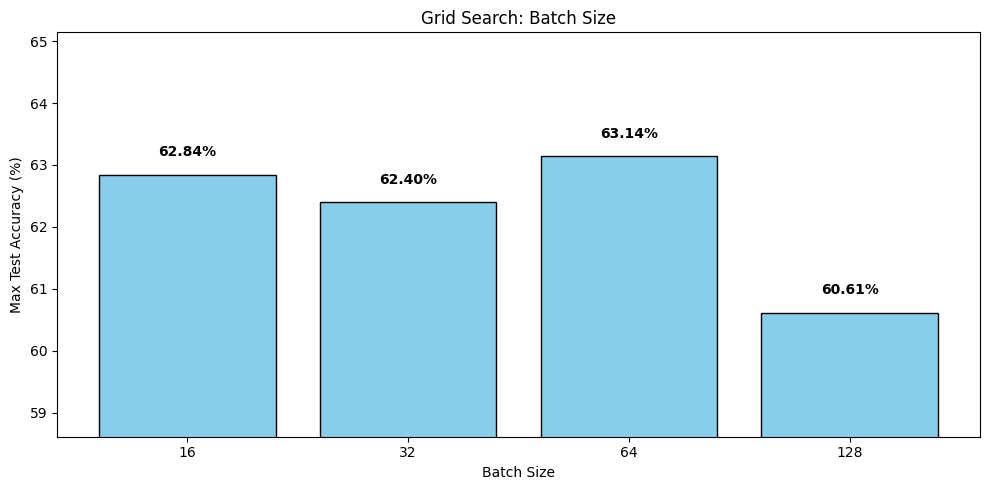

In [19]:
plt.figure(figsize=(10, 5))

batch_accs_final = [res['max_acc'] for res in results_batch_final]
plt.bar(range(len(batch_sizes)), batch_accs_final, tick_label=batch_sizes, color='skyblue', edgecolor='black')
plt.xlabel('Batch Size')
plt.ylabel('Max Test Accuracy (%)')
plt.title('Grid Search: Batch Size')
plt.ylim(min(batch_accs_final) - 2, max(batch_accs_final) + 2)

for i, acc in enumerate(batch_accs_final):
    plt.text(i, acc + 0.3, f'{acc:.2f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

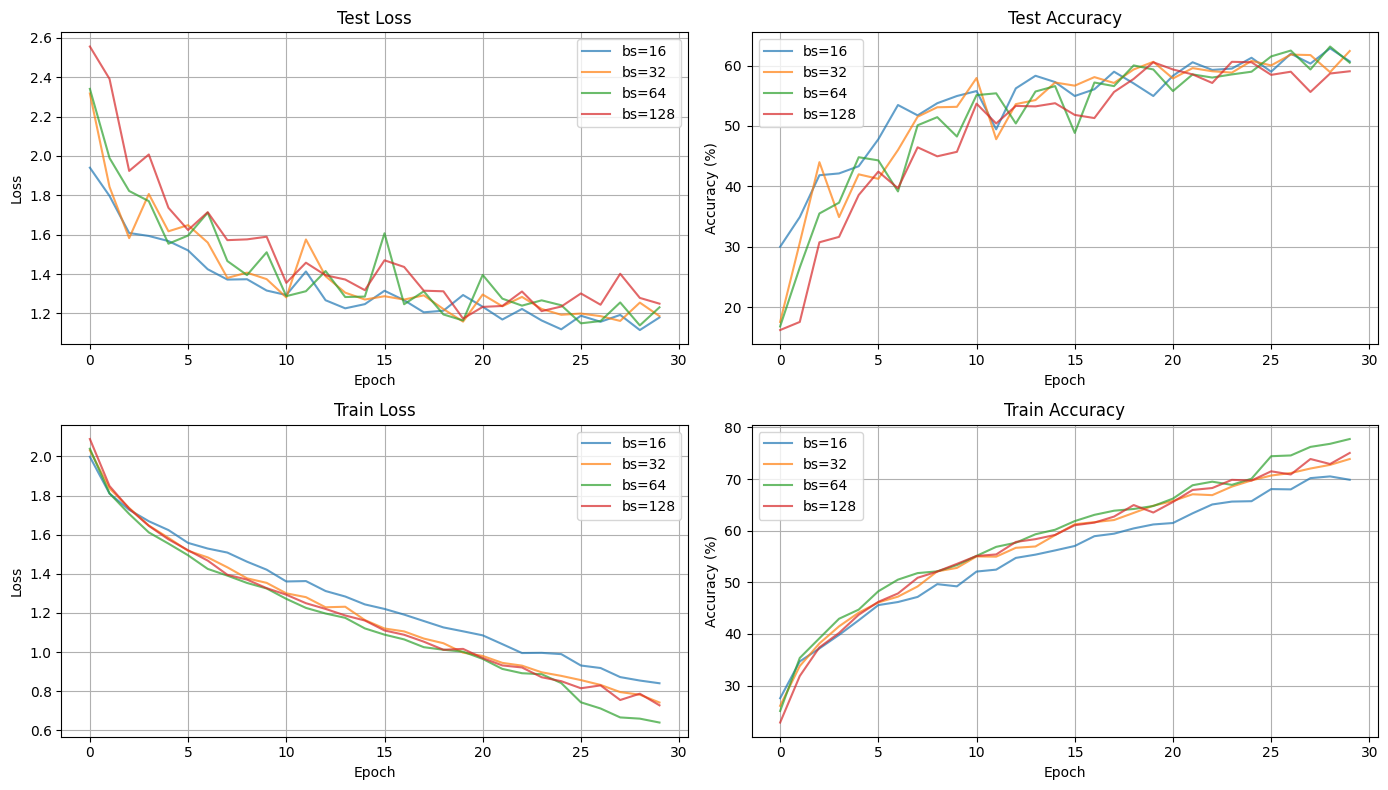

In [20]:
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
for res in results_batch_final:
    label = f"bs={res['batch_size']}"
    plt.plot(res['test_losses'], label=label, alpha=0.7)
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
for res in results_batch_final:
    label = f"bs={res['batch_size']}"
    plt.plot(res['test_accs'], label=label, alpha=0.7)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()

plt.subplot(2, 2, 3)
for res in results_batch_final:
    label = f"bs={res['batch_size']}"
    plt.plot(res['train_losses'], label=label, alpha=0.7)
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(2, 2, 4)
for res in results_batch_final:
    label = f"bs={res['batch_size']}"
    plt.plot(res['train_accs'], label=label, alpha=0.7)
plt.title('Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

## Итоговые результаты

In [23]:
best_params_final = {
    'lr': best_lr_final,
    'weight_decay': best_wd_final,
    'dropout_conv': best_dc_final,
    'dropout_fc': best_df_final,
    'batch_size': best_batch_final['batch_size'],
    'channels': best_channels_final,
    'max_accuracy': best_batch_final['max_acc']
}

for key, value in best_params_final.items():
    if key == 'channels':
        print(f'{key}:')
        for layer, ch in value.items():
            print(f'  {layer}: {ch}')
    else:
        print(f'{key}: {value}')

lr: 0.001
weight_decay: 1e-05
dropout_conv: 0.3
dropout_fc: 0.6
batch_size: 64
channels:
  conv1: 37
  conv2: 72
  conv3: 150
  conv4: 298
  conv5: 614
  fc1: 853
  fc2: 385
max_accuracy: 63.14221891288161
